# Signal Modulation classification 4
Experiment with architecture and data

## Imports

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple

sys.path.append("..") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [4]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = True
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "../data/RML2016.10a/RML2016.10a_dict.pkl" # radioml dataset
TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_mixed_0-30_30k"

# Deployment
# model_name = "simc_2_mixed_0-30_data"
model_name = "simc_4_MIXED_v2"
# MODELS_DIR = f'models_{model_name}_MIXED_0-30_DATA/'
MODELS_DIR = f'models_{model_name}_MIXED_v2/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
snrs = [0, 5, 10, 15, 20, 25, 30]


Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
# reload_module("tools.data")
# from tools.data import load_data_simc_v1
# # labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR)
# labels, data = load_data_simc_v1(
#     classes=modulations, 
#     path=Path(TRAIN_DATA_DIR), 
#     model_dtype=MODEL_DATA_TYPE
# )

# Commented code loads mixed datasst 
# snr_to_labels_data = {}
# for snr in snrs:
#     print(f"snr={snr}")
#     labels, data = load_data_simc_v1(
#         classes=modulations, 
#         path=Path(TRAIN_DATA_DIR) / f"train_data_SIMC1_2k_SNR_{snr}", 
#         model_dtype=MODEL_DATA_TYPE
#     )
#     snr_to_labels_data[snr] = (labels, data)




In [6]:
# np.save("mixed_ds_v2_data.npy", data)
# np.save("mixed_ds_v2_labels.npy", labels)

In [7]:
data = np.load("mixed_ds_v2_data.npy")
labels = np.load("mixed_ds_v2_labels.npy")

In [8]:
print(modulations)
print(labels.shape)
print(data.shape)

# crmrn_ds_keys = list(crmrn_ds.keys())
# print(crmrn_ds_keys)
# print(len(crmrn_ds.keys())) # 20 (snr -20 to 20 with step 2) * 11
# for key in crmrn_ds:
#     print(len(crmrn_ds[key]), end=", ")
# print()
# print(crmrn_ds[list(crmrn_ds.keys())[0]].shape)

['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(330000,)
(330000, 1, 1024, 2)


### Data preprocessing

There are 27_500 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [9]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [10]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [11]:
# Should save some memory
del data
del labels

## Model creation


In [19]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_simc_2():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_simc_3():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_simc_4_v1():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 16), padding="same", name="CNN1_", activation="tanh")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 16), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 16), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    CNN5_1 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_1")(ReLU5)
    BN5_1 = CustomBatchNorm(name="BN5_1")(CNN5_1)
    ReLU5_1 = layers.ReLU()(BN5_1)


    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5_1)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)
    CNN6_1 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_1")(ReLU6)
    BN6_1 = CustomBatchNorm(name="BN6_1")(CNN6_1)
    ReLU6_1 = layers.ReLU()(BN6_1)


    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6_1)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FL1 = layers.Flatten(name="FC1_preFlatten1")(AP1)

    # FC1 = layers.Dense(256, name="FC1")(FL1)
    # BN7 = CustomBatchNorm(name="BN7_")(FC1)
    # FC2 = layers.Dense(128, name="FC2")(BN7)
    # BN8 = CustomBatchNorm(name="BN8_")(FC2)
    # FC3 = layers.Dense(11, name="FC3")(BN8)
    # SoftMax = layers.Softmax()(FC3)

    FC1 = layers.Dense(256, name="FC1")(FL1)
    BN7 = CustomBatchNorm(name="BN7_")(FC1)
    FC3 = layers.Dense(11, name="FC3")(BN7)
    SoftMax = layers.Softmax()(FC3)

    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


In [24]:
model = create_model_simc_4_v1()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 1024, 2)]      0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 1024, 32)       1056      
                                                                 
 BN1_ (CustomBatchNorm)      (None, 1, 1024, 32)       128       
                                                                 
 re_lu_17 (ReLU)             (None, 1, 1024, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 512, 32)       0         
 g2D)                                                            
                                                                 
 CNN2_ (Conv2D)              (None, 1, 512, 48)        24624     
                                                           

In [25]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [26]:
def step_decay(epoch):
    lrate = 0.05
    factor = epoch // 3
    lrate /= (2**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

# N_EPOCHS = 16 
# BATCH_SIZE = 256
N_EPOCHS = 5
BATCH_SIZE = 128
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


Epoch 1/5
2063/2063 [==============================] - 65s 30ms/step - loss: 0.6977 - accuracy: 0.7306 - val_loss: 0.5935 - val_accuracy: 0.7833 - lr: 0.0500
Epoch 2/5
2063/2063 [==============================] - 61s 29ms/step - loss: 0.4256 - accuracy: 0.8395 - val_loss: 0.3595 - val_accuracy: 0.8670 - lr: 0.0500
Epoch 3/5
2063/2063 [==============================] - 61s 30ms/step - loss: 0.3890 - accuracy: 0.8545 - val_loss: 0.9424 - val_accuracy: 0.7060 - lr: 0.0500
Epoch 4/5
2063/2063 [==============================] - 60s 29ms/step - loss: 0.3127 - accuracy: 0.8816 - val_loss: 0.2995 - val_accuracy: 0.8904 - lr: 0.0250
Epoch 5/5
2063/2063 [==============================] - 60s 29ms/step - loss: 0.3015 - accuracy: 0.8864 - val_loss: 0.3765 - val_accuracy: 0.8653 - lr: 0.0250


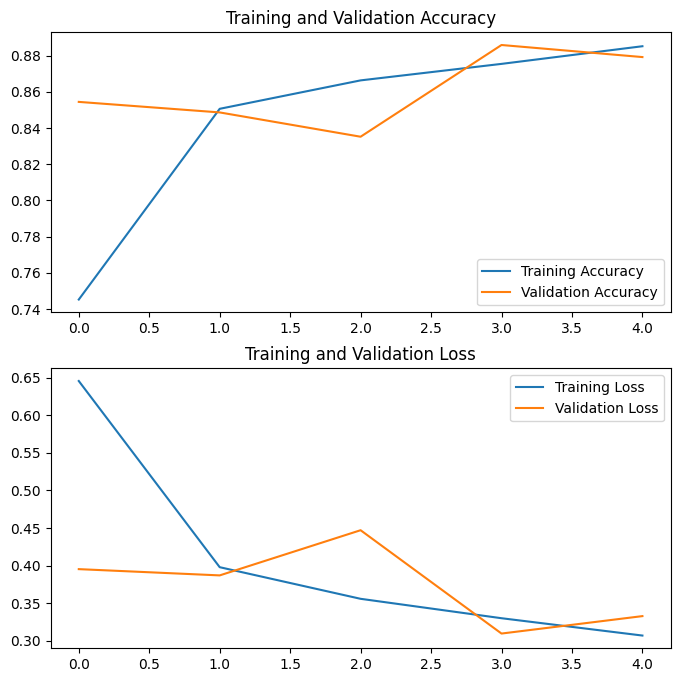

In [23]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [17]:
test_preds = model.predict(test_data)

1032/1032 [==============================] - 6s 5ms/step


In [18]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[ 2  5  2  2  2  8 10  3  6  9]
[ 0  5  2  2  2  0 10  3  6  9]


Overall test accuracy: 0.9156969696969697
16QAM test accuracy: 0.917912822144448
64QAM test accuracy: 0.9713611859838275
8PSK test accuracy: 0.7359178263750829
B-FM test accuracy: 0.9996530187369882
BPSK test accuracy: 0.8277575356078172
CPFSK test accuracy: 1.0
DSB-AM test accuracy: 0.954635761589404
GFSK test accuracy: 0.9893687707641196
PAM4 test accuracy: 0.8818818818818819
QPSK test accuracy: 0.910039113428944
SSB-AM test accuracy: 0.890587835541964


<Axes: >

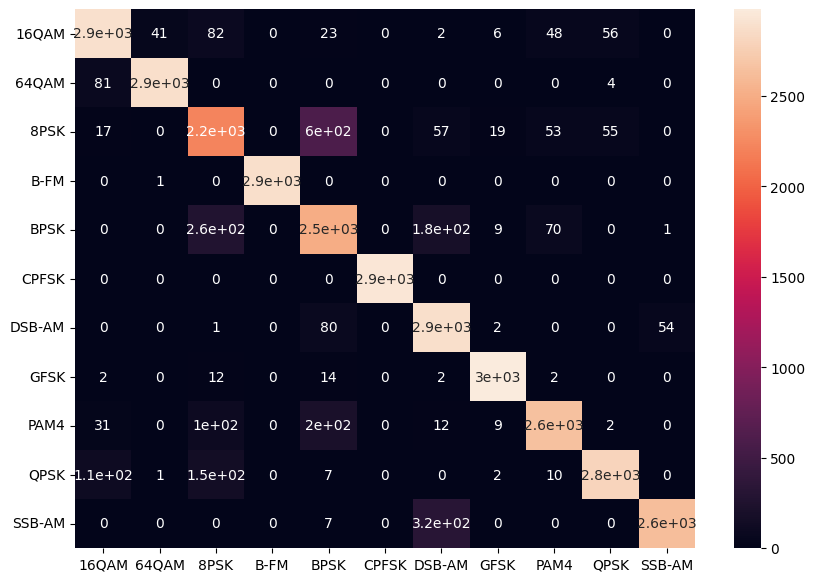

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [20]:
snrs = list(range(0, 30))
def snr_by_idx(idx):
    snr_idx = (idx % 30000) // 1000
    return snrs[snr_idx]


In [21]:
print(test_indecies[:40])
test_snrs = np.array([snr_by_idx(idx) for idx in test_indecies])
print(test_snrs[:40])
print(test_indecies.shape)

[  8493 161468  63562  69654  77698   5653 312027  90606 189301 289967
  80714 313356 152259 293836  89863  27984 117193  35360 300975 104524
 297767 208144 224251 132536  97298  99682 131015 241174 200210 168923
 296635 239579 312609  95164  13693 295779  33245  67951  60293  54139]
[ 8 11  3  9 17  5 12  0  9 19 20 13  2 23 29 27 27  5  0 14 27 28 14 12
  7  9 11  1 20 18 26 29 12  5 13 25  3  7  0 24]
(33000,)


In [22]:
snr_to_acc = {}
for snr in range(0, 30):
    cur_test_indecies = np.where(test_snrs == snr)[0]
    cur_test_data = test_data[cur_test_indecies]
    cur_test_labels = test_labels[cur_test_indecies]
    cur_pred = model.predict(cur_test_data, verbose=0)

    cur_pred_labels = np.argmax(cur_pred, axis=1)
    print(f"snr={snr}")
    acc = accuracy_score(cur_test_labels, cur_pred_labels)
    print(f"Overall test accuracy: {acc}")
    snr_to_acc[snr] = acc


snr=0
Overall test accuracy: 0.9082397003745318
snr=1
Overall test accuracy: 0.9048888888888889
snr=2
Overall test accuracy: 0.9155597722960152
snr=3
Overall test accuracy: 0.9071294559099438
snr=4
Overall test accuracy: 0.9139784946236559
snr=5
Overall test accuracy: 0.9155435759209344
snr=6
Overall test accuracy: 0.9191829484902309
snr=7
Overall test accuracy: 0.9200726612170754
snr=8
Overall test accuracy: 0.9190391459074733
snr=9
Overall test accuracy: 0.9312169312169312
snr=10
Overall test accuracy: 0.9269195189639223
snr=11
Overall test accuracy: 0.9287020109689214
snr=12
Overall test accuracy: 0.9146451033243486
snr=13
Overall test accuracy: 0.92520035618878
snr=14
Overall test accuracy: 0.9211775878442545
snr=15
Overall test accuracy: 0.9078467153284672
snr=16
Overall test accuracy: 0.9157801418439716
snr=17
Overall test accuracy: 0.9148936170212766
snr=18
Overall test accuracy: 0.9141274238227147
snr=19
Overall test accuracy: 0.9181395348837209
snr=20
Overall test accuracy: 0.

(0.0, 1.0)

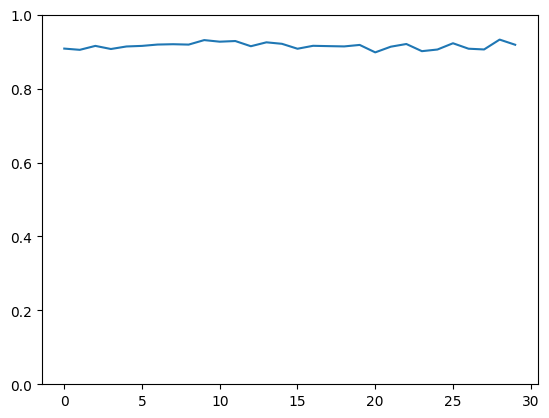

In [23]:
plt.plot(list(snr_to_acc.keys()), list(snr_to_acc.values()))
plt.ylim([0, 1])

In [33]:
# plt.plot([0, 5, 10, 15, 20, 25, 30], [0.49772727272727274 ,0.6522727272727272, 0.7654545454545455, 0.8245454545454546, 0.8581818181818182, 0.86, 0.8686363636363637])
# plt.ylim([0, 1])

### Mode deployment

In [34]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_3_MIXED_v2_MIXED_v2/model/assets


INFO:tensorflow:Assets written to: models_simc_3_MIXED_v2_MIXED_v2/model/assets


In [35]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

1546008

In [36]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [15]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


409696

In [16]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [39]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[2 5 2 2 2 0 6 3 6 9]
[ 0  5  2  2  2  0 10  3  6  9]


Overall test accuracy: 0.9170303030303031
16QAM test accuracy: 0.92141266306077
64QAM test accuracy: 0.9703504043126685
8PSK test accuracy: 0.7726971504307488
B-FM test accuracy: 1.0
BPSK test accuracy: 0.8539251407750911
CPFSK test accuracy: 0.9996589358799455
DSB-AM test accuracy: 0.9599337748344371
GFSK test accuracy: 0.9857142857142858
PAM4 test accuracy: 0.8758758758758759
QPSK test accuracy: 0.8888526727509778
SSB-AM test accuracy: 0.8647638464152225


<Axes: >

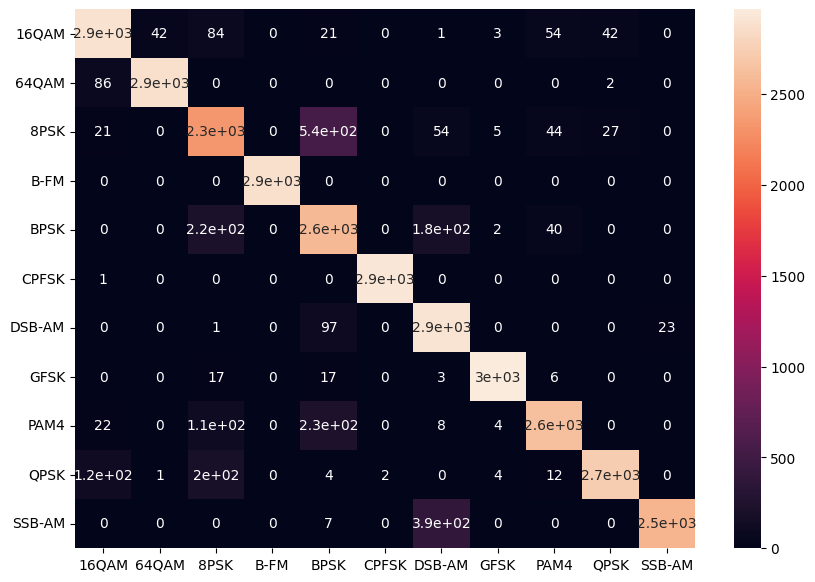

In [40]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [41]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.02734375 0.         0.890625   0.         0.0078125  0.
 0.         0.         0.05078125 0.02734375 0.        ]


In [17]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=False,
    epsilon=20,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 416.76it/s]
